In [1]:
import ee
import pandas as pd
import numpy as np
import plotnine
from plotnine import *

import sys
from tqdm.auto import tqdm

from dfply import *

# get the cropland area (crop/water) after urban encroachment
from Modules.Parallize_df import parallelize_dataframe


In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
# append sys_path, and import custom moduls
sys.path.append('./')
sys.path.append('../Step_1_UNET_predict_future_urbanization/torch_modules')

from Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# import the 30m landcover of 2010
LUCC_2019 = ee.Image("users/wangjinzhulala/Paper_3/01_LUCC_1990_2019_china/CLCD_v01_2019").mask(NCP_img_mask)
lucc_code = dict(zip([f"{i}" for i in range(1,10)],['Cropland','Forest','Shrub','Grassland','Water','Sonw','Barren','Impervious','Wetland']))
# the crop land of 2010
cropland_2019 = LUCC_2019.eq(1).mask(NCP_img_mask)

# the GAEZ_2010_cropland layers
actual_area = pd.read_pickle('./result_csv/actual_area.pkl')
GAEZ_area_2020 = pd.read_pickle('./result_csv/GAEZ_cropland_2020_corrected.pkl')

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

# urban imgs
NCP_urban_maps = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble")
NCP_urban_2019 = NCP_urban_maps.gte(1).mask(NCP_img_mask)

Unet_transition_potential = ee.Image(f"users/wangjinzhulala/Paper_3/06_Urban_projection/trainsition_potential_{proj_yr_selected[0]}_{proj_yr_selected[1]}")

# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# threshould for UNET_tarnsition potential map
SSP_urban_count = pd.read_csv('../Step_1_UNET_predict_future_urbanization/result_csv/SSP_GDP_Pop_future_pred_treshold.csv')

### 1) Get historical and future urban maps

In [5]:
# function to 1) clip an img with a boundary, then 2) binarize the img
def clip_binarize(img,shp,threshold):

  # 1) clip the img
  img = ee.Image(img).clip(shp)

  # 2) binarize the img
  img = ee.Image(img).gte(threshold)

  return img

In [6]:
# get future urban maps

# 1) get the future urban maps under different SSPs
SSP_future_urban_map = SSP_urban_count.copy()
SSP_future_urban_map['Urban_map'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold']),1)

SSP_future_urban_map['Urban_map_top'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold_top']),1)

SSP_future_urban_map['Urban_map_bot'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold_bot']),1)

# 2) mosaic the urban maps of differnect provinces but the same year/ssp into a single img
SSP_future_urban_map = SSP_future_urban_map.groupby(['Scenario','year'])\
                    .apply(lambda x,idx:[ee.ImageCollection(x['Urban_map'].tolist()).mosaic(),
                                         ee.ImageCollection(x['Urban_map_top'].tolist()).mosaic(),
                                         ee.ImageCollection(x['Urban_map_bot'].tolist()).mosaic()],1).reset_index()

SSP_future_urban_map[['Urban_map','Urban_map_top','Urban_map_bot']] =  SSP_future_urban_map[0].values.tolist()
SSP_future_urban_map = SSP_future_urban_map.drop(columns=0)                           
SSP_future_urban_map

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_17620\1584681402.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Scenario,year,Urban_map,Urban_map_top,Urban_map_bot
0,SSP1,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,SSP1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,SSP1,2030,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2035,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2040,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...
80,SSP5,2080,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
81,SSP5,2085,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
82,SSP5,2090,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
83,SSP5,2095,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### compute the area of pred/historical urban

In [7]:
# function to compute areas of predicted urban maps
def get_stats(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    ssp = row['Scenario']
    year = row['year']

    urban_img = row['Urban_map']
    urban_img_bot = row['Urban_map_top']
    urban_img_top = row['Urban_map_bot']

    # get the input images
    in_img = ee.Image([urban_img.mask(urban_img.gte(1)),
               urban_img_bot.mask(urban_img_bot.gte(1)),
               urban_img_top.mask(urban_img_top.gte(1))])
    
    # mask img 0 value
    in_img = in_img.updateMask(in_img.gte(0))
    
    in_img_size = in_img.bandNames().size().getInfo()

    # compute the area of the input img
    stats = ee.Image([ee.Image().pixelArea()]*in_img_size)\
          .updateMask(in_img)\
          .reduceRegions(collection=NCP_shp,
                  scale=30,
                  reducer='sum').getInfo()

    # contructe the stats_df, divide 1e9 is to convert m2 to 1000 km2
    stats_data = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['area']/1e9,
                                  i['properties']['area_1']/1e9,
                                  i['properties']['area_2']/1e9] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_1000_km2','area_1000_km2_bot','area_1000_km2_top']
    stats_data['year'] = year
    stats_data['ssp'] = ssp

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [8]:
# # get the stats
# future_pred_area = parallelize_dataframe(SSP_future_urban_map,get_stats,30)

# # save to disk
# future_pred_area.to_csv('./result_csv/future_pred_area.csv',index=False)

# read data
future_pred_area = pd.read_csv('./result_csv/future_pred_area.csv')

In [9]:
future_pred_area

,Province,area_1000_km2,area_1000_km2_bot,area_1000_km2_top,year,ssp
0,Shandong,24.755892,25.800669,23.639050,2020,SSP1
1,Henan,19.519899,20.533549,18.462789,2020,SSP1
2,Beijing,3.270219,4.350006,2.212793,2020,SSP1
3,Tianjin,2.739711,3.634174,1.826362,2020,SSP1
4,Hebei,15.996800,17.124866,14.957512,2020,SSP1
...,...,...,...,...,...,...
590,Beijing,9.330183,16.319255,0.705075,2100,SSP5
591,Tianjin,8.615347,11.641565,3.328113,2100,SSP5
592,Hebei,45.708092,62.369306,35.535089,2100,SSP5
593,Anhui,38.096290,44.810187,31.980883,2100,SSP5


#### compute the historical urban area

In [10]:
# read NCP urban 
historical_urbans = {k:[ee.Image(NCP_urban_maps.gte(v))] for k,v in zip(range(1991,2019,3),range(10,0,-1))}
historical_urban_df = pd.DataFrame(historical_urbans).T.reset_index()
historical_urban_df.columns = ['year','img']

In [11]:
# function to compute the urban area for each province
def compute_area(in_df):
  print(' ',end='',flush=True)

  out_dfs = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    year = row['year']
    img = ee.Image().pixelArea().updateMask(row['img'])
    
    stats = img.reduceRegions(collection=NCP_shp,scale=30,reducer='sum').getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()

    stats_df['year'] = year
    stats_df.columns = ['Province','area_m2','year']

    out_dfs.append(stats_df)

  return pd.concat(out_dfs)

In [12]:
# get stats
# historical_urban_area = parallelize_dataframe(historical_urban_df,compute_area,10)
# historical_urban_area['area_1000_km2'] = historical_urban_area['area_m2']/1000/1000/1000
# historical_urban_area['area_k_ha'] = historical_urban_area['area_m2']/100/100/1000
# historical_urban_area.to_csv('./result_csv/historical_urban_area.csv',index=False)

historical_urban_area = pd.read_csv('./result_csv/historical_urban_area.csv')

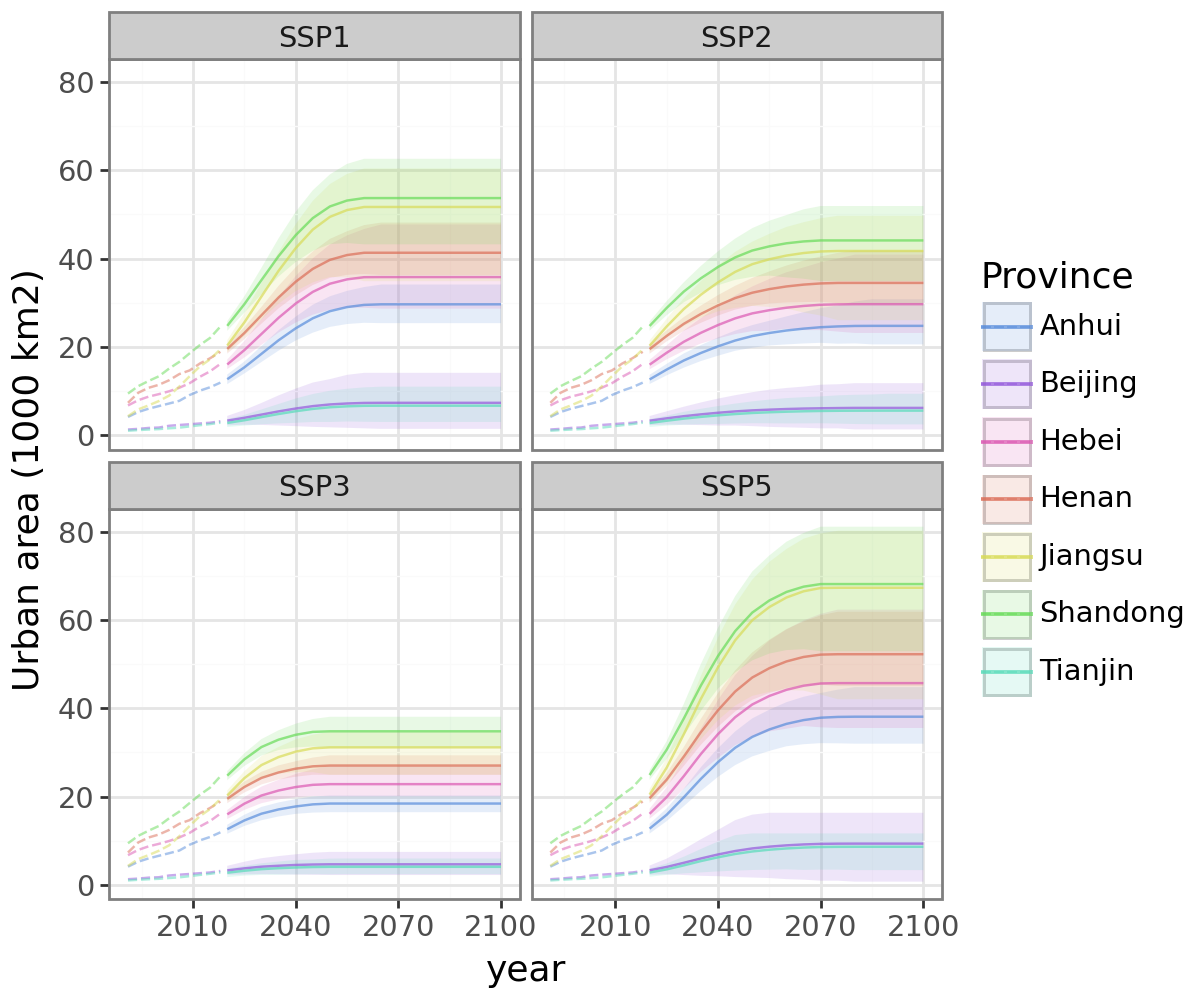

In [13]:
# plot the area change
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

g = (ggplot()
  # urban area hist
  + geom_line(historical_urban_area,aes(x='year',y='area_1000_km2',color='Province'),alpha=0.5,linetype='dashed')
  # urban area pred
  + geom_ribbon(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',ymin='area_1000_km2_bot',
                                    ymax='area_1000_km2_top',fill='Province'),alpha=0.15)
  + geom_line(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',y='area_1000_km2',color='Province'),alpha=0.7)

  + facet_wrap('ssp',nrow=2)
  + theme_bw(base_size=13)
  + scale_color_discrete(h=.6) 
  + scale_fill_discrete(h=.6)  
  + ylab('Urban area (1000 km2)')
)

# show img
g

In [14]:
# g.save('/content/result_2_1_1_pred_urban_area.svg')

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


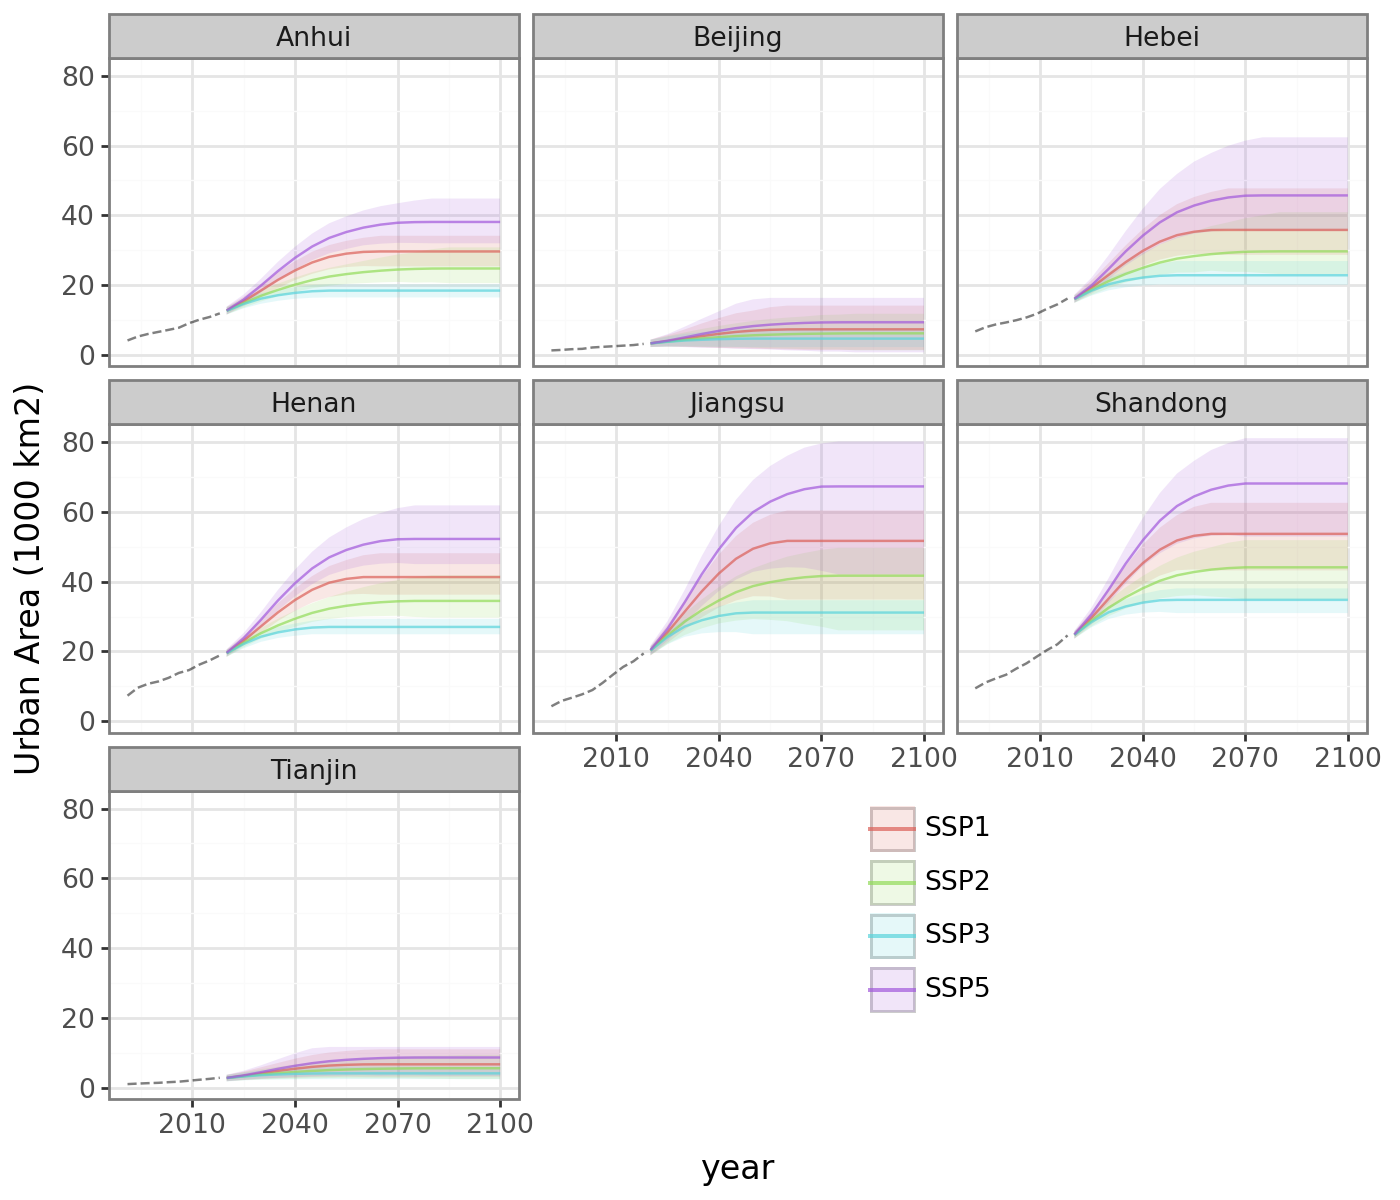

In [15]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # urban area hist
  + geom_line(historical_urban_area,aes(x='year',y='area_1000_km2'),alpha=0.5,linetype='dashed')
  # urban area pred
  + geom_ribbon(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',ymin='area_1000_km2_bot',
                                    ymax='area_1000_km2_top',fill='ssp'),alpha=0.15)
  + geom_line(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',y='area_1000_km2',color='ssp'),alpha=0.7)
  + facet_wrap('Province',ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Urban Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_position=(0.67,0.1),legend_background=element_blank())
 )

g

In [16]:
# g.save('/content/result_2_1_2_pred_urban_area.svg')

#### Overlay the future_urban_maps with cropland_2019 to get urbanization encroachment on cropland

In [17]:
# overlay urban-furture with cropland-2010 to get the urban encroachment on cropland
SSP_future_urban_map['Urban_encroachment_map'] = SSP_future_urban_map.apply(lambda row: cropland_2019.add(row['Urban_map']).eq(2),axis=1)
SSP_future_urban_map['Urban_encroachment_map_top'] = SSP_future_urban_map.apply(lambda row: cropland_2019.add(row['Urban_map_top']).eq(2),axis=1)
SSP_future_urban_map['Urban_encroachment_map_bot'] = SSP_future_urban_map.apply(lambda row: cropland_2019.add(row['Urban_map_bot']).eq(2),axis=1)

SSP_future_urban_map.head()

,Scenario,year,Urban_map,Urban_map_top,Urban_map_bot,Urban_encroachment_map,Urban_encroachment_map_top,Urban_encroachment_map_bot
0,SSP1,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,SSP1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,SSP1,2030,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2035,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2040,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [18]:
# img = SSP_future_urban_map.iloc[0]['Urban_excroachment_map']

# # sanity check: --> download the imgs to see if they make sense
# geom = ee.Geometry.Polygon(
#         [[[114.77418110831297, 35.562628464176825],
#          [114.77418110831297, 34.618753486305835],
#          [116.11451313956297, 34.618753486305835],
#          [116.11451313956297, 35.562628464176825]]])


# # img = SSP_future_urban_map.iloc[0]['Urban_future_map']
# print(img.getDownloadUrl(dict(name='img',region=geom,scale=30,format='GEO_TIFF')))

#### compute the urban_encroachment_area

In [19]:
SSP_future_urban_map.head()

,Scenario,year,Urban_map,Urban_map_top,Urban_map_bot,Urban_encroachment_map,Urban_encroachment_map_top,Urban_encroachment_map_bot
0,SSP1,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,SSP1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,SSP1,2030,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2035,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2040,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [20]:
# function to compute the urban_encroachment area for each province
def compute_encroachment(in_df):
  print(' ',end='',flush=True)

  out_dfs = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    year = row['year']
    ssp = row['Scenario']
    
    # get the img in 2020
    img_2020 = SSP_future_urban_map.query('year == 2020 & Scenario == @ssp')['Urban_encroachment_map'].tolist()[0]

    # get input image; Subtract the encroachment in 2020 to make sure crop land not decrease in 2020
    in_img = ee.Image([row['Urban_encroachment_map'],row['Urban_encroachment_map_top'],row['Urban_encroachment_map_bot']]).subtract(img_2020)\
              .rename(['mean','top','bot'])
    
    # prepare area_img and reducer
    area_img = ee.Image([ee.Image().pixelArea()]*3).updateMask(in_img)
    reducer = ee.Reducer.sum().repeat(3)

    # get stats
    stats = area_img.reduceRegions(collection=NCP_shp,
                                   scale=30,
                                   reducer=reducer).getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                             for i in stats['features']}).T.reset_index()

    stats_df['Scenario'] = ssp
    stats_df['year'] = year
    
    stats_df.columns = ['Province','urban_excroachment_m2_mean','urban_excroachment_m2_mean_top',
               'urban_excroachment_m2_mean_bot','Scenario','year']

    out_dfs.append(stats_df)

  return pd.concat(out_dfs).reset_index(drop=True)

In [21]:
# # get stats
# urban_encroachment_area_df = parallelize_dataframe(SSP_future_urban_map,compute_encroachment,40)
# urban_encroachment_area_df['encroach_area_kha_mean'] = urban_encroachment_area_df['urban_excroachment_m2_mean']/10000/1000
# urban_encroachment_area_df['encroach_area_kha_top'] = urban_encroachment_area_df['urban_excroachment_m2_mean_top']/10000/1000
# urban_encroachment_area_df['encroach_area_kha_bot'] = urban_encroachment_area_df['urban_excroachment_m2_mean_bot']/10000/1000

# # drop unnecessary cols
# urban_encroachment_area_df = urban_encroachment_area_df >> drop(['urban_excroachment_m2_mean','urban_excroachment_m2_mean_top',
#                                     'urban_excroachment_m2_mean_bot'])
# # save to disk
# urban_encroachment_area_df.to_csv('./result_csv/urban_encroachment_area_df.csv',index=False)

# load csv
urban_encroachment_area_df = pd.read_csv('./result_csv/urban_encroachment_area_df.csv')

# change kha to 1000km2
urban_encroachment_area_df[['encroach_area_1000km2_mean','encroach_area_1000km2_top','encroach_area_1000km2_bot']] = \
  urban_encroachment_area_df[['encroach_area_kha_mean','encroach_area_kha_top','encroach_area_kha_bot']] / 100

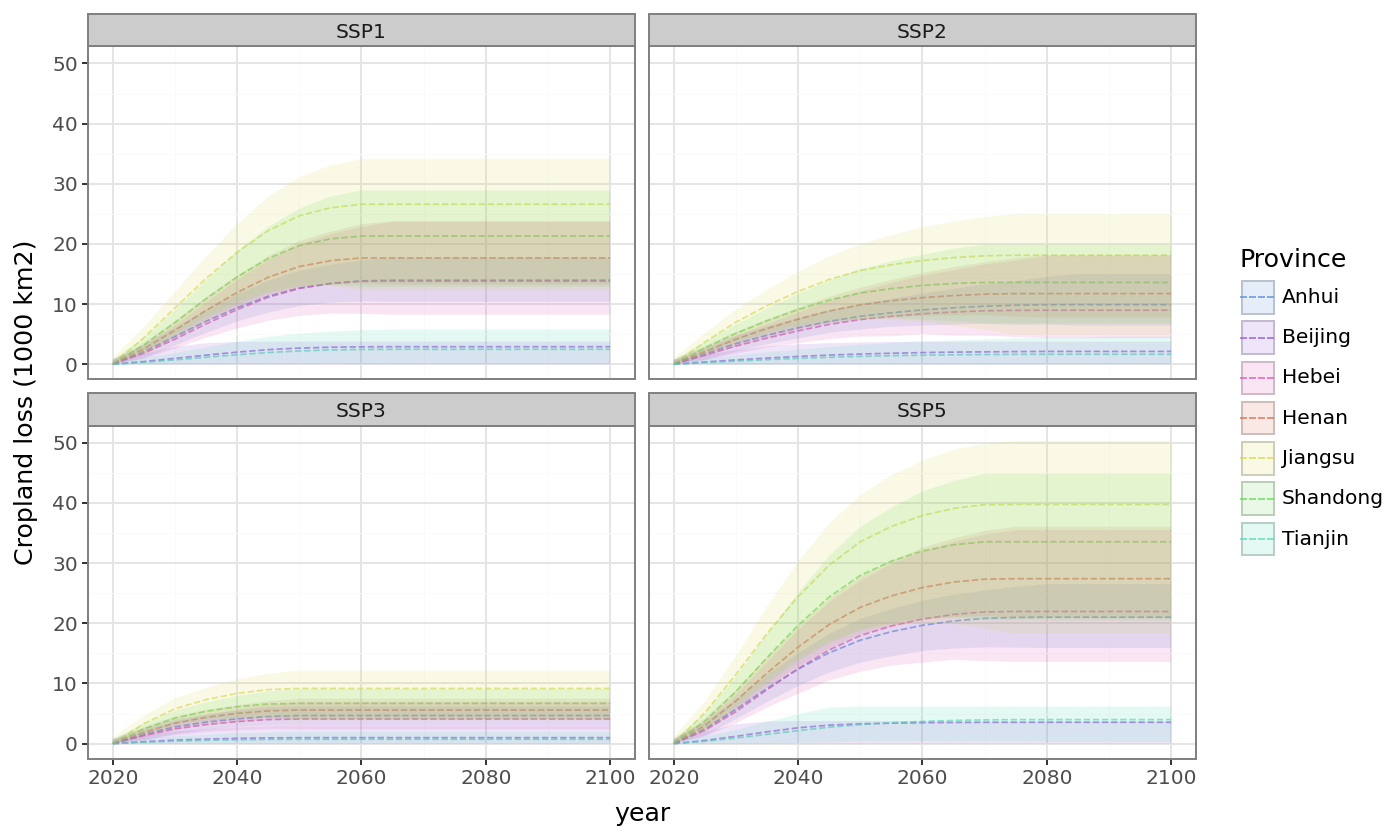

In [22]:
# plot the area change
plotnine.options.figure_size = (10,6)
plotnine.options.dpi = 70

g = (ggplot()
  # historical urban encroachment
  + geom_line(urban_encroachment_area_df>> mask(~X.Scenario.isin(['SSP4']))
              ,aes(x='year',y='encroach_area_1000km2_mean',color='Province'),alpha=0.7,linetype='dashed')
  # pred urban encroachment
  + geom_ribbon(urban_encroachment_area_df >> mask(~X.Scenario.isin(['SSP4'])),
                aes(x='year',ymin='encroach_area_1000km2_bot', ymax='encroach_area_1000km2_top',fill='Province'),alpha=0.15)
  + facet_wrap('Scenario',nrow=2)
  + theme_bw(base_size=13)
  + scale_color_discrete(h=.6) 
  + scale_fill_discrete(h=.6)  
  + ylab('Cropland loss (1000 km2)')
  # + theme(legend_position=(1,0.5))
)

g

In [23]:
# g.save('/content/result_2_2_urban_encroach_cropland_area.svg')

### 2) Compute the area of urban encroachment on cropland for each GAEZ grid cell

#### 2-1) First to convert GAEZ imgs to vectors

In [24]:
# fucntion to create a vector shp that has the same
# spatial resolution as GAEZ img

# define the scale for converting raw_float to intergers
GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_2011_2040_RCP26")
to_path = 'users/wangjinzhulala/Paper_3/04_GAEZ_shp'

vector = GAEZ_img.multiply(0).add(ee.Image.random().multiply(1e8)).toInt().reduceToVectors(
                          geometry=NCP_shp.geometry(), 
                          scale=GAEZ_pix_scale, 
                          maxPixels=1e13, 
                          tileScale=2, 
                          geometryInNativeProjection=True)

# # export vector to GEE
# task = ee.batch.Export.table.toAsset(
#     collection = vector, 
#     description = 'Export GAEZ_vector', 
#     assetId = f'{to_path}/GAEZ_vector'
# )

# task.start()

#### 2-2) Compute the urban excroachment in each GAEZ grid cell, then export the fe_col

In [25]:
# get the GAEZ shp file
GAEZ_shp = ee.FeatureCollection("users/wangjinzhulala/Paper_3/04_GAEZ_shp/GAEZ_vector")
stats_to_path = 'users/wangjinzhulala/Paper_3/05_GAEZ_shp_stats'

In [26]:
# compute the urban encroachment_area in each GAEZ cell
for idx,row in SSP_future_urban_map.iterrows():

  # get properties
  scenario = row['Scenario']
  name = f"{row['Scenario']}_{row['year']}"

  if scenario == 'Historical':
    img = img_bot = img_top = row['Urban_encroachment_map']
    img = img.rename('encroachment')
    img_bot = img_bot.rename('encroachment_bot')
    img_top = img_top.rename('encroachment_top')
  else:
    img = row['Urban_encroachment_map'].rename('encroachment')
    img_bot = row['Urban_encroachment_map_bot'].rename('encroachment_bot')
    img_top = row['Urban_encroachment_map_top'].rename('encroachment_top')
  
  # zonal statistics
  in_imgs = ee.Image([ee.Image.pixelArea()]*3).updateMask(ee.Image([img,img_bot,img_top]))
  stats = in_imgs.reduceRegions(collection = GAEZ_shp, 
                                reducer = 'sum', 
                                scale = 30)
  
  stats = stats.map(lambda fe: fe.set('encroachment',fe.get('area'),
                                      'encroachment_bot',fe.get('area_1'),
                                      'encroachment_top',fe.get('area_2')))
  
  # export
  task = ee.batch.Export.table.toAsset(
      collection = ee.FeatureCollection(stats), 
      description = name, 
      assetId = f'{stats_to_path}/{name}'
  )

  # # start the export
  # task.start()
  # print(name)

In [27]:
# get the shp_stats
crops = ['Wetland_rice','Maize','Wheat']
shp_stats = !earthengine ls users/wangjinzhulala/Paper_3/05_GAEZ_shp_stats
shp_stats_filter = [i for i in shp_stats if not any(j in i for j in crops)]

In [28]:
# construct the shp_stats_df
shp_stats_df = pd.DataFrame({'GAEZ_shp_stats':[ee.FeatureCollection(fe) for fe in shp_stats_filter]})
shp_stats_df[['Scenario','year']] = [i.split('/')[-1].split('_') for i in shp_stats_filter]
shp_stats_df['year'] = shp_stats_df['year'].astype(int)

In [29]:
# append GAEZ shp to urban maps
SSP_future_urban_map_stats = shp_stats_df.copy()
SSP_future_urban_map_stats['crop'] = [GAEZ_area_2020['crop'].tolist()]*len(SSP_future_urban_map_stats)
SSP_future_urban_map_stats['water'] = [GAEZ_area_2020['water'].tolist()]*len(SSP_future_urban_map_stats)
SSP_future_urban_map_stats['GAEZ_2020_cropland'] = [GAEZ_area_2020['GAEZ_2020_cropland_corrcted'].tolist()]*len(SSP_future_urban_map_stats)

# explode the crop/water columns to conect urban maps with GAEZ cropland shp
SSP_future_urban_map_stats = SSP_future_urban_map_stats.explode(['crop','water','GAEZ_2020_cropland']).reset_index(drop=True)
SSP_future_urban_map_stats

,GAEZ_shp_stats,Scenario,year,crop,water,GAEZ_2020_cropland
0,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Maize,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ..."
1,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Maize,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ..."
2,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wetland_rice,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ..."
3,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wetland_rice,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ..."
4,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wheat,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...
517,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Maize,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ..."
518,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wetland_rice,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ..."
519,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wetland_rice,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ..."
520,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wheat,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ..."


In [30]:
# # sanity check: --> download the imgs to see if they make sense

# fe_col = (SSP_future_urban_map_stats >> mask(X.Scenario=='SSP2',X.year==2020,X.crop=='Wheat',X.water=='Irrigated'))['GAEZ_shp_stats'].tolist()[0]
# img = ee.Image().toFloat().paint(featureCollection=fe_col,color='encroachment')

# print(img.getDownloadUrl(dict(name='img',region=NCP_shp.geometry(),scale=GAEZ_pix_scale,format='GEO_TIFF')))

In [31]:
# compute the total cropland area in the NCP
total_area_img = ee.ImageCollection([ee.Image(img).unmask() for img in  GAEZ_area_2020['GAEZ_2020_cropland_corrcted']]).sum()
total_area_val = total_area_img.reduceRegion(reducer='sum', geometry=NCP_shp.geometry(), scale=GAEZ_pix_scale).getInfo()['b1']

# compute the area of each crop in the NCP
crop_area = list(map(lambda img:img.reduceRegion(reducer='sum',geometry=NCP_shp.geometry(),scale=GAEZ_pix_scale).getInfo()['b1'],
         [ee.Image(img).unmask() for img in  GAEZ_area_2020['GAEZ_2020_cropland_corrcted']]))

# compute the area_ratio of each crop to the total cropland
crop_area_ratio = pd.DataFrame({'crop':GAEZ_area_2020['crop'],'water':GAEZ_area_2020['water'],'ratio':np.array(crop_area)/total_area_val})
crop_area_ratio

,crop,water,ratio
0,Maize,Irrigated,0.274941
1,Maize,Rainfed,0.087413
2,Wetland_rice,Irrigated,0.154750
3,Wetland_rice,Rainfed,0.000000
4,Wheat,Irrigated,0.416498
5,Wheat,Rainfed,0.057663


### 3) compute the cropland area after urbanization

#### 3-1) compute the encroachment

In [32]:
# append crop_area_ratio of each rainfed/irrigated to the stats
SSP_future_urban_map_stats_water_ratio = SSP_future_urban_map_stats.merge(actual_area)
SSP_future_urban_map_stats_water_ratio = SSP_future_urban_map_stats_water_ratio[['Scenario', 'year', 'crop', 'water', 'GAEZ_shp_stats', 'GAEZ_2020_cropland','area_ratio']]
                                          
SSP_future_urban_map_stats_water_ratio.head()

,Scenario,year,crop,water,GAEZ_shp_stats,GAEZ_2020_cropland,area_ratio
0,Historical,2012,Maize,Irrigated,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Historical,2012,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Historical,2012,Wetland_rice,Irrigated,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Historical,2012,Wetland_rice,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Historical,2012,Wheat,Irrigated,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [33]:
# function to compute urban encroachment on cropland
def compute_urban_encroachment(row):

  # get properties
  fe = row['GAEZ_shp_stats']
  GAEZ_cropland_2020 = ee.Image(row['GAEZ_2020_cropland'])
  area_ratio_img = row['area_ratio']

  # get the feature in 2020
  fe_2020 = SSP_future_urban_map_stats_water_ratio.query('year == 2020 and Scenario == @row["Scenario"] and crop == @row["crop"] and water == @row["water"]')['GAEZ_shp_stats'].tolist()[0]
  img_2020 = ee.Image().paint(featureCollection=fe_2020,color='encroachment').multiply(area_ratio_img)

  encroach_img = ee.Image().paint(featureCollection=fe,color='encroachment').multiply(area_ratio_img).subtract(img_2020).divide(10000*1000)
  encroach_img_bot = ee.Image().paint(featureCollection=fe,color='encroachment_bot').multiply(area_ratio_img).subtract(img_2020).divide(10000*1000)
  encroach_img_top = ee.Image().paint(featureCollection=fe,color='encroachment_top').multiply(area_ratio_img).subtract(img_2020).divide(10000*1000)

  # get the future farmland_area (kha) 
  future_farmland = GAEZ_cropland_2020.subtract(encroach_img).rename(f'encroachment_led_farmland')
  future_farmland_bot = GAEZ_cropland_2020.subtract(encroach_img_bot).rename(f'encroachment_led_farmland_bot')
  future_farmland_top = GAEZ_cropland_2020.subtract(encroach_img_top).rename(f'encroachment_led_farmland_top')

  # convert negative values to 0, because cropland area can't be negative
  future_farmland = future_farmland.mask(future_farmland.gt(0)).unmask()
  future_farmland_bot = future_farmland_bot.mask(future_farmland_bot.gt(0)).unmask()
  future_farmland_top = future_farmland_top.mask(future_farmland_top.gt(0)).unmask()

  future_farmland_combine = ee.Image([future_farmland,future_farmland_bot,future_farmland_top])

  # return future famland area as raster img
  return future_farmland_combine

In [34]:
# compute future harvested area and save the df to disk
urban_encroach_img = SSP_future_urban_map_stats_water_ratio.copy().query('year >= 2020')
urban_encroach_img['cropland_encroached_by_urban'] = urban_encroach_img.apply(lambda row:compute_urban_encroachment(row),1)

urban_encroach_img = urban_encroach_img >> select(['Scenario','year','crop','water','cropland_encroached_by_urban'])
urban_encroach_img.to_pickle('./result_csv/urban_encroach_img.pkl')

In [35]:
# # sanity check: --> download the imgs to see if they make sense

# img = urban_encroach_img.iloc[0]['cropland_encroached_by_urban']
# print(img.getDownloadUrl(dict(name='img',region=NCP_shp.geometry(),scale=GAEZ_pix_scale,format='GEO_TIFF')))

#### 3-2) validate the encroachment

In [50]:
# function to compute cropland area after urban encroachment
def compute_cropland_by_encroachment(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    ssp = row['Scenario']
    year = row['year']
    water = row['water']
    crop = row['crop']

    # judge if the img comes from the historical 
    if ssp == 'Historical':
      in_img = ee.Image([row['cropland_encroached_by_urban'].select('encroachment_led_farmland')]*3)
    else:
      in_img = row['cropland_encroached_by_urban']

    # compute the area of the input img
    stats = in_img.reduceRegions(collection=NCP_shp,
                                 scale=GAEZ_pix_scale,
                                 reducer=ee.Reducer.sum().repeat(3)).getInfo()

    # contructe the stats_df
    stats_data = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_after_encroachment_kha','area_after_encroachment_kha_top','area_after_encroachment_kha_bot']
    
    stats_data['Scenario'] = ssp
    stats_data['crop'] = crop
    stats_data['water'] = water
    stats_data['year'] = year
    stats_data['area_after_encroachment_ci_kha'] = (stats_data['area_after_encroachment_kha_top'] - stats_data['area_after_encroachment_kha_bot'])/2

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [ ]:
# cropland_area_after_encroachment = parallelize_dataframe(urban_encroach_img,compute_cropland_by_encroachment,40).reset_index(drop=True)

# # save to disk
# cropland_area_after_encroachment.to_csv('./result_csv/cropland_area_after_encroachment.csv',index=False)

# read data
cropland_area_after_encroachment = pd.read_csv('./result_csv/cropland_area_after_encroachment.csv')

# get the total cropland area
cropland_area_after_encroachment_sum = cropland_area_after_encroachment.groupby(['Scenario','year','Province']).sum(numeric_only=True).reset_index()
cropland_area_after_encroachment_sum

In [54]:
# get the sum of yearbook cropland area records
yearbook_area_sum = yearbook_area.groupby(['Province','year']).sum(numeric_only=True).reset_index()
yearbook_area_sum.tail()

,Province,year,area_yearbook_kha
128,Tianjin,2016,353.33
129,Tianjin,2017,340.68
130,Tianjin,2018,337.51
131,Tianjin,2019,327.43
132,Tianjin,2020,336.27


c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


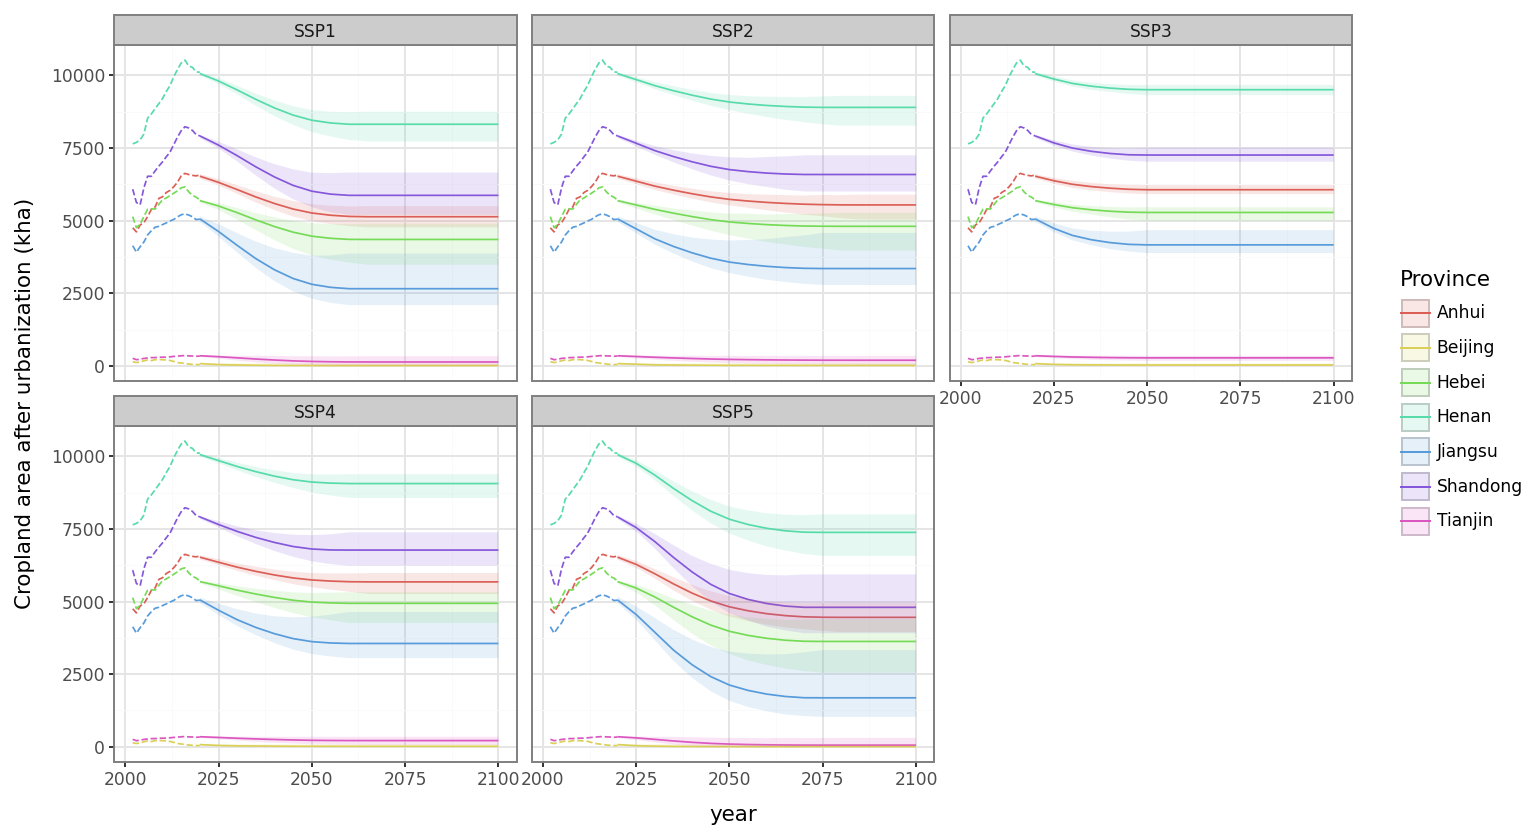

In [55]:
# plot the area change
plotnine.options.figure_size = (11,6)
plotnine.options.dip = 100

# plot the cropland_area_after_encroachment_sum
g= (ggplot()
 # yearbook cropland area
 + geom_line(yearbook_area_sum,aes(x='year',y='area_yearbook_kha',color='Province'),linetype='dashed')
 # cropland after urban encroachment
 + geom_line(cropland_area_after_encroachment_sum,aes(x='year',y='area_after_encroachment_kha',color='Province'))
 + geom_ribbon(cropland_area_after_encroachment_sum,
          aes(x='year',ymax='area_after_encroachment_kha_top',ymin='area_after_encroachment_kha_bot',fill='Province'),alpha=0.15)
 + facet_wrap(['Scenario'],ncol=3)
 + theme_bw()
 + theme(subplots_adjust={'wspace': 0.15})
 + ylab('Cropland area after urbanization (kha)')
 )

g


In [40]:
# g.save('/content/sup_7_cropland_area_after_urbanization.svg')